In [73]:
import sqlite3
import pandasql as ps

import pandas as pd
import numpy as np

import openpyxl

import plotnine as p9

import warnings
warnings.filterwarnings('ignore')

In [31]:
OUT_PATH = 'D:/fvs_calibration/data/interim'

In [32]:
#read in source tables 
DB_PATH = 'D:FIA/FIADB_CA.db'

con = sqlite3.connect(DB_PATH)
# grab NC stands
stands = pd.read_sql_query("select STAND_CN, STAND_ID, INV_YEAR, REGION, FOREST from FVS_STANDINIT_COND where VARIANT = 'NC'", con)

In [33]:
# scrape stand_id so remeasurement ids match
#stands['INV_YEAR'] = stands['INV_YEAR'].astype(int)
stands['STAND_ID'] = stands['STAND_ID'].str[0:3] + stands['STAND_ID'].str[10:]

In [34]:
# drop stands with no remeasurment data
stands = stands.sort_values(by=['STAND_ID', 'INV_YEAR', 'REGION', 'FOREST'])
remeasured_stands = stands[stands.duplicated(subset=['STAND_ID'], keep=False)]

In [35]:
# grab the trees and cond tables
cond = pd.read_sql_query("select CN, PLT_CN, CONDID from COND", con)
trees = pd.read_sql_query("select PLT_CN, CONDID, INVYR, TREE, STATUSCD, SPCD, DIA, HT, VOLCFNET, VOLCFGRS from TREE", con)

In [36]:
# use cond table to get plt_cn to match with trees table
trees_id = trees.merge(cond, how='left', on=['PLT_CN', 'CONDID'])

In [45]:
# grab tress for stands in our remeasured stands database
stand_trees = ps.sqldf("""select PLT_CN, CONDID, TREE, STATUSCD, SPCD, DIA, HT, VOLCFNET, VOLCFGRS, STAND_ID, REGION, FOREST 
                          from trees_id t join remeasured_stands s on t.CN = s.STAND_CN AND t.INVYR = s.INV_YEAR
                          WHERE t.DIA >= 3.0""")

In [65]:
# export to excel for use in National Volume Estimator Library (NVEL)
stand_trees.to_excel(OUT_PATH + '/NC_trees_for_NVEL.xlsx')

Bring data back in from Excel with volumes calcuated using NVEL. Save updated workbook as NC_trees_for_NVEL_calc
['EQUATION'] = '=VolumeEquationNumber(L2,M$,1,F2,2)'
['VOLCALC'] = '=calcFiaVol(N2,F2,G2,H2)'

In [70]:
volume_calc = pd.read_excel(OUT_PATH + '/NC_trees_for_NVEL_calc.xlsx')

In [83]:
# calculate difference between FIA calculated volumes and volumes calc va NVEL
# need to drop records where volume_calc = NULL or VOLCALC = 0
qa = volume_calc.loc[~((volume_calc['VOLCFGRS'] == '') |  (volume_calc['VOLCALC'] == 0))]
qa['diff'] = abs((qa['VOLCFGRS'] - qa['VOLCALC']))
qa['per_diff'] = round(qa['diff']/qa['VOLCALC']*100, 3)
qa['per_diff'].describe()

count    59977.000000
mean        13.246799
std         27.862397
min          0.000000
25%          0.348000
50%          2.979000
75%         13.681000
max        435.024000
Name: per_diff, dtype: float64

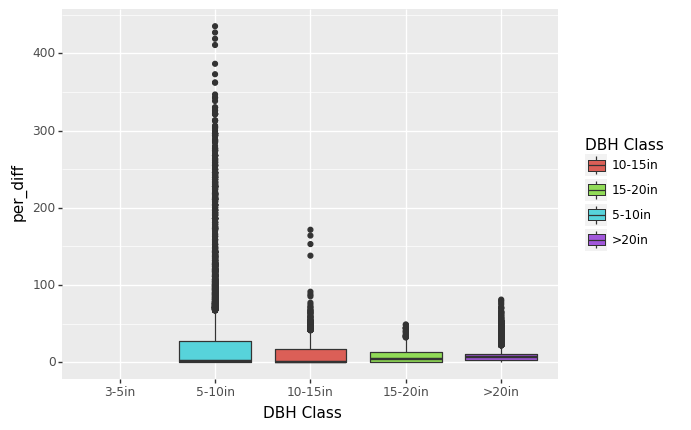

<ggplot: (184372402732)>

In [84]:
# assign size classes: 3-5, 5-10, 10-15, 15-20, >20
conditions = [(qa['DIA'] < 5),
              (qa['DIA'] >= 5) & (qa['DIA'] < 10),
              (qa['DIA'] >= 10) & (qa['DIA'] <= 15), 
              (qa['DIA'] >= 15) & (qa['DIA'] <= 20), 
              (qa['DIA'] >= 20)]

values = ['3-5in', '5-10in', '10-15in', '15-20in', '>20in']

qa["DBH Class"] = np.select(conditions, values)
qa=qa.sort_values(by=['DIA'])

(p9.ggplot(qa, aes(x = 'DBH Class', y ='per_diff', fill='DBH Class' ))
    + p9.geom_boxplot()
    + p9.scale_x_discrete(limits = ('3-5in', '5-10in', '10-15in', '15-20in', '>20in')))

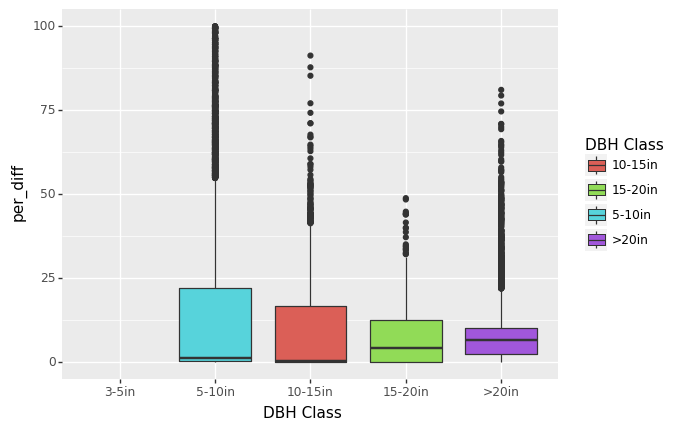

<ggplot: (184290752684)>

In [85]:
(p9.ggplot(qa, aes(x = 'DBH Class', y ='per_diff', fill='DBH Class' ))
    + p9.geom_boxplot()
    + p9.scale_x_discrete(limits = ('3-5in', '5-10in', '10-15in', '15-20in', '>20in'))
    + p9.scale_y_continuous(limits = (0, 100)))